# Action Detection

## Set up enviornment

In [0]:
!pip3 install torch torchvision

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import numpy as np
import scipy
from scipy.io import loadmat
from random import shuffle
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [0]:
os.chdir('drive/Colab_Notebooks/c3d/')

## Data Loader

In [0]:
video_rootdir="./ReCompress_Videos"
mask_rootdir="./puppet_mask"
pose_rootdir="./joint_positions"

video_pathes=[]
mask_pathes=[]
pose_pathes=[]
for root, dirs, files in os.walk(video_rootdir):
    for file in files:
        video_pathes.append(os.path.join(root, file))

for root, dirs, files in os.walk(mask_rootdir):
    for file in files:
        mask_pathes.append(os.path.join(root, file)) 

for root, dirs, files in os.walk(pose_rootdir):
    for file in files:
        pose_pathes.append(os.path.join(root, file))
        
video_pathes = sorted(video_pathes)
mask_pathes = sorted(mask_pathes)
pose_pathes = sorted(pose_pathes)

In [0]:
video_pathes_train, video_pathes_valid, mask_pathes_train, mask_pathes_valid, pose_pathes_train, pose_pathes_valid = train_test_split(video_pathes, mask_pathes, pose_pathes, test_size=0.3)
class_names=[name for name in os.listdir(video_rootdir)]
class_num=len(class_names)

In [0]:
class JHMDB(torch.utils.data.Dataset):
    def __init__(self, video_pathes, mask_pathes, pose_pathes, class_names, F = 15):
        
        self.data = {'video': [], 'label': [], 'mask':[], 'pose':[], 'scale':[]}
        
        self.classdict = {}
        for i, x in enumerate(class_names):
            self.classdict[x] = i

        video_num=len(video_pathes)
        mask_num=len(mask_pathes)

        for i in range(video_num):
            video=[]
            cap = cv2.VideoCapture(video_pathes[i])
            has_frame=True
            while(has_frame):
                _, frame = cap.read()
                has_frame = frame is not None

                if has_frame:
                    frame = cv2.resize(frame, (112, 112), interpolation = cv2.INTER_CUBIC)
                    video.append(frame)
            cap.release()
                    
            self.data['video'].append(video)

            mask_mat = loadmat(mask_pathes[i]) 
            masks = cv2.resize(mask_mat['part_mask'], (112, 112), interpolation = cv2.INTER_CUBIC) # (112, 112, F)
            self.data['mask'].append(masks)
            
            self.data['label'].append(video_pathes[i].split('/')[-2])
            
            pose_mat = loadmat(pose_pathes[i])['pos_img']
            scale = loadmat(pose_pathes[i])['scale']
            self.data['pose'].append(pose_mat)
            self.data['scale'].append(scale[0]) # redundant dim
    
    def _compute_mean(self):
        meanstd_file = './data/jhmdbmean'
        if os.path.isfile(meanstd_file):
            meanstd = torch.load(meanstd_file)
        else:
            mean = torch.zeros(3)
            std = torch.zeros(3)
            for videos in self.data['video']:
                for img in videos:
                    # CxHxW
                    mean += np.reshape(img, (img.shape(0), -1)).mean(1)
                    std += np.reshape(img, (img.shape(0), -1)).std(1)
            mean /= len(self.train)
            std /= len(self.train)
            meanstd = {
                'mean': mean,
                'std': std,
                }
            torch.save(meanstd, meanstd_file)
        if self.is_train:
            print('    Mean: %.4f, %.4f, %.4f' % (meanstd['mean'][0], meanstd['mean'][1], meanstd['mean'][2]))
            print('    Std:  %.4f, %.4f, %.4f' % (meanstd['std'][0], meanstd['std'][1], meanstd['std'][2]))
            
        return meanstd['mean'], meanstd['std']
        
    def __getitem__(self, index):
        # video (C, F, 112, 112)
        # mask (112, 112, F)
        # pose (2, 15, F)
        # scale (F)
        # label (1), 
        # randomly select 15 consecutive frames (F = 15)
        F = 15
        frame_num = self.data['mask'][index].shape[2]
        frame_shuffle=list(range(frame_num))
        shuffle(frame_shuffle)
        selected_frame=sorted(frame_shuffle[0:F])
       
        # change pose position according to resize
        pose_data = torch.from_numpy(self.data['pose'][index][:,:,selected_frame].astype('float'))
        pose_data[0,:,:] = pose_data[0,:,:] * 112 / 320
        pose_data[1,:,:] = pose_data[1,:,:] * 112 / 240
        
        
        video = np.transpose(np.array(self.data['video'][index])[selected_frame,:,:,:], (3, 0, 1, 2))
        return torch.FloatTensor(video), \
            torch.from_numpy(self.data['mask'][index][:,:,selected_frame].astype('float')), \
            pose_data, \
            torch.from_numpy(self.data['scale'][index][selected_frame].astype('float')), \
            torch.LongTensor([self.classdict[self.data['label'][index]]])
        
    def __len__(self):
        return len(self.data['scale'])

In [0]:
train_dataset = JHMDB(video_pathes_train, mask_pathes_train, pose_pathes_train, class_names)
valid_dataset = JHMDB(video_pathes_valid, mask_pathes_valid, pose_pathes_valid, class_names)

In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=10, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(train_dataset,batch_size=10, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=10, shuffle=False)

## Model

N \* 3 \* 15 \* 112 \* 112 --> N \* 64 \* 15 \* 56 \* 56 -->  N \* 128 \* 8 \* 28 \* 28 --> N \* 256 \* 4 \* 14 \* 14 --> N \* 512 \* 2 \* 7 \* 7 --> N \* 512 \* 1 \* 4 \* 4

In [0]:
class C3D(nn.Module):
    """
    The C3D network as described in [1].
    """

    def __init__(self,class_num):
        super(C3D, self).__init__()

        self.conv1 = nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

        self.conv2 = nn.Conv3d(64, 128, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(1, 0, 0))

        self.conv3a = nn.Conv3d(128, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv3b = nn.Conv3d(256, 256, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv4a = nn.Conv3d(256, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv4b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool4 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv5a = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.conv5b = nn.Conv3d(512, 512, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.pool5 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 1, 1))

        self.fc6 = nn.Linear(8192, 4096)
        self.fc7 = nn.Linear(4096, 4096)
        self.fc8 = nn.Linear(4096, class_num)

        self.dropout = nn.Dropout(p=0.5)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def forward(self, x):

        h = self.relu(self.conv1(x))
        h = self.pool1(h)

        h = self.relu(self.conv2(h))
        h = self.pool2(h)

        h = self.relu(self.conv3a(h))
        h = self.relu(self.conv3b(h))
        h = self.pool3(h)

        h = self.relu(self.conv4a(h))
        h = self.relu(self.conv4b(h))
        h = self.pool4(h)

        h = self.relu(self.conv5a(h))
        h = self.relu(self.conv5b(h))
        h = self.pool5(h)

        h = h.view(-1, 8192)
        h = self.relu(self.fc6(h))
        h = self.dropout(h)
        h = self.relu(self.fc7(h))
        h = self.dropout(h)

        logits = self.fc8(h)

        return logits

## Train

In [0]:
def eval_video(net,test_video,test_label):
    net.eval()
    _, indices=torch.max(net(test_video),1)
    correct_prediction=torch.eq(indices,test_label.squeeze(1)).data.sum()
    return correct_prediction.cpu().numpy()

In [11]:
criterion = nn.CrossEntropyLoss().cuda()
net=C3D(class_num).cuda()

#Initialize from pre-trained model
pretrained_dict = torch.load('./c3d.pickle')
pretrained_dict = {k: v for k, v in pretrained_dict.items() if not k.startswith( 'fc8' )}
model_dict=net.state_dict()
model_dict.update(pretrained_dict) 
net.load_state_dict(model_dict)

print(net)

init_lr=0.001
def exp_lr_scheduler(optimizer, epoch, init_lr=init_lr, lr_decay_epoch=10):
    """Decay learning rate by a factor of 2 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

optimizer = torch.optim.SGD(net.parameters(), init_lr)

C3D(
  (conv1): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool2): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(1, 0, 0), dilation=1, ceil_mode=False)
  (conv3a): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv3b): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool3): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (conv4b): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (pool4): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5a): Conv3d(512, 512, kernel_size=(3, 3, 3),

In [0]:
def train(epoch,step,log):
    net.train()
    train_loss = 0
    step_cnt = 0
    
    for index,x in enumerate(train_loader):
        train_video=Variable(x[0]).cuda()
        train_video_label=Variable(x[4]).cuda()
        train_result=net(train_video)
        
        # forward
        loss = criterion(train_result,train_video_label.squeeze(1))
        train_loss += loss.data[0]
        step_cnt += train_video_label.shape[0]
        step += train_video_label.shape[0]
        # backward pass and update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Log to screen        
        log_text = 'epoch %d, step %d, loss: %.4f' % (epoch, step, train_loss / step_cnt)
        print(log_text)
        log['loss_step'].append(step)
        log['loss'].append(train_loss / step_cnt)
        train_loss = 0
        step_cnt = 0
        
        
        
    # Evaluate the model
    net.eval()
    test_size=0
    correct_num=0
    for y in valid_loader:
        test_video=Variable(y[0]).cuda()
        test_video_label=Variable(y[4]).cuda()
        test_size += test_video_label.shape[0]
        correct_num += eval_video(net,test_video,test_video_label)
    accuracy = correct_num/test_size*100 
    print(accuracy)
    log['accuracy_step'].append(step)
    log['accuracy'].append(accuracy)
    net.train()
        
    return step

In [13]:
step=0
log = {'loss_step': [], 'loss': [], 'accuracy_step':[], 'accuracy':[]}
for epoch in range(20):
    step = train(epoch,step,log)
    exp_lr_scheduler(optimizer, epoch, init_lr, lr_decay_epoch=10)
torch.save(net.state_dict(), "./c3d_without_attention.pickle")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


epoch 0, step 10, loss: 0.3092
epoch 0, step 20, loss: 0.3254
epoch 0, step 30, loss: 0.2925
epoch 0, step 40, loss: 0.3194
epoch 0, step 50, loss: 0.3188
epoch 0, step 60, loss: 0.2997
epoch 0, step 70, loss: 0.2952
epoch 0, step 80, loss: 0.2901
epoch 0, step 90, loss: 0.3196
epoch 0, step 100, loss: 0.2874
epoch 0, step 110, loss: 0.2932
epoch 0, step 120, loss: 0.3072
epoch 0, step 130, loss: 0.2946
epoch 0, step 140, loss: 0.3004
epoch 0, step 150, loss: 0.2946
epoch 0, step 160, loss: 0.2706
epoch 0, step 170, loss: 0.2876
epoch 0, step 180, loss: 0.2774
epoch 0, step 190, loss: 0.2781
epoch 0, step 200, loss: 0.2698
epoch 0, step 210, loss: 0.2925
epoch 0, step 220, loss: 0.3031
epoch 0, step 230, loss: 0.2810
epoch 0, step 240, loss: 0.2698
epoch 0, step 250, loss: 0.2648
epoch 0, step 260, loss: 0.2868
epoch 0, step 270, loss: 0.2838
epoch 0, step 280, loss: 0.2336
epoch 0, step 290, loss: 0.2890
epoch 0, step 300, loss: 0.2689
epoch 0, step 310, loss: 0.2518
epoch 0, step 320

epoch 1, step 779, loss: 0.2050
epoch 1, step 789, loss: 0.1748
epoch 1, step 799, loss: 0.1441
epoch 1, step 809, loss: 0.1501
epoch 1, step 819, loss: 0.2003
epoch 1, step 829, loss: 0.1068
epoch 1, step 839, loss: 0.1835
epoch 1, step 849, loss: 0.1235
epoch 1, step 859, loss: 0.1551
epoch 1, step 869, loss: 0.1044
epoch 1, step 879, loss: 0.1202
epoch 1, step 889, loss: 0.0946
epoch 1, step 899, loss: 0.1828
epoch 1, step 909, loss: 0.1740
epoch 1, step 919, loss: 0.1483
epoch 1, step 929, loss: 0.2331
epoch 1, step 939, loss: 0.1571
epoch 1, step 949, loss: 0.1314
epoch 1, step 959, loss: 0.0876
epoch 1, step 969, loss: 0.2164
epoch 1, step 979, loss: 0.1857
epoch 1, step 989, loss: 0.1317
epoch 1, step 999, loss: 0.1102
epoch 1, step 1009, loss: 0.1075
epoch 1, step 1019, loss: 0.1173
epoch 1, step 1029, loss: 0.1415
epoch 1, step 1039, loss: 0.1368
epoch 1, step 1049, loss: 0.1567
epoch 1, step 1059, loss: 0.1398
epoch 1, step 1069, loss: 0.1112
epoch 1, step 1079, loss: 0.2024


epoch 2, step 1548, loss: 0.1136
epoch 2, step 1558, loss: 0.0989
epoch 2, step 1568, loss: 0.1229
epoch 2, step 1578, loss: 0.0931
epoch 2, step 1588, loss: 0.0993
epoch 2, step 1598, loss: 0.0764
epoch 2, step 1608, loss: 0.0247
epoch 2, step 1618, loss: 0.0687
epoch 2, step 1628, loss: 0.0949
epoch 2, step 1638, loss: 0.1012
epoch 2, step 1648, loss: 0.1295
epoch 2, step 1658, loss: 0.0764
epoch 2, step 1668, loss: 0.0732
epoch 2, step 1678, loss: 0.1299
epoch 2, step 1688, loss: 0.0896
epoch 2, step 1698, loss: 0.1001
epoch 2, step 1708, loss: 0.0803
epoch 2, step 1718, loss: 0.0502
epoch 2, step 1728, loss: 0.0997
epoch 2, step 1738, loss: 0.1252
epoch 2, step 1748, loss: 0.1396
epoch 2, step 1758, loss: 0.1219
epoch 2, step 1768, loss: 0.0241
epoch 2, step 1778, loss: 0.1140
epoch 2, step 1788, loss: 0.0360
epoch 2, step 1798, loss: 0.1302
epoch 2, step 1808, loss: 0.0503
epoch 2, step 1818, loss: 0.0595
epoch 2, step 1828, loss: 0.0594
epoch 2, step 1838, loss: 0.0585
epoch 2, s

epoch 3, step 2307, loss: 0.0840
epoch 3, step 2317, loss: 0.0829
epoch 3, step 2327, loss: 0.1500
epoch 3, step 2337, loss: 0.0396
epoch 3, step 2347, loss: 0.0449
epoch 3, step 2357, loss: 0.0502
epoch 3, step 2367, loss: 0.0621
epoch 3, step 2377, loss: 0.0345
epoch 3, step 2387, loss: 0.0996
epoch 3, step 2397, loss: 0.0597
epoch 3, step 2407, loss: 0.0825
epoch 3, step 2417, loss: 0.0312
epoch 3, step 2427, loss: 0.0269
epoch 3, step 2437, loss: 0.0623
epoch 3, step 2447, loss: 0.0565
epoch 3, step 2457, loss: 0.0656
epoch 3, step 2467, loss: 0.0610
epoch 3, step 2477, loss: 0.0440
epoch 3, step 2487, loss: 0.0071
epoch 3, step 2497, loss: 0.0730
epoch 3, step 2507, loss: 0.0273
epoch 3, step 2517, loss: 0.0957
epoch 3, step 2527, loss: 0.0843
epoch 3, step 2537, loss: 0.0736
epoch 3, step 2547, loss: 0.0270
epoch 3, step 2557, loss: 0.0333
epoch 3, step 2567, loss: 0.0405
epoch 3, step 2577, loss: 0.0523
epoch 3, step 2587, loss: 0.0588
epoch 3, step 2596, loss: 0.0934
75.6272401

epoch 4, step 3066, loss: 0.0557
epoch 4, step 3076, loss: 0.0195
epoch 4, step 3086, loss: 0.0196
epoch 4, step 3096, loss: 0.0185
epoch 4, step 3106, loss: 0.0172
epoch 4, step 3116, loss: 0.0784
epoch 4, step 3126, loss: 0.0471
epoch 4, step 3136, loss: 0.0979
epoch 4, step 3146, loss: 0.0415
epoch 4, step 3156, loss: 0.0166
epoch 4, step 3166, loss: 0.0238
epoch 4, step 3176, loss: 0.0472
epoch 4, step 3186, loss: 0.0240
epoch 4, step 3196, loss: 0.0177
epoch 4, step 3206, loss: 0.0700
epoch 4, step 3216, loss: 0.0653
epoch 4, step 3226, loss: 0.0333
epoch 4, step 3236, loss: 0.0783
epoch 4, step 3245, loss: 0.0188
75.62724014336918
epoch 5, step 3255, loss: 0.0173
epoch 5, step 3265, loss: 0.0071
epoch 5, step 3275, loss: 0.0073
epoch 5, step 3285, loss: 0.0036
epoch 5, step 3295, loss: 0.0061
epoch 5, step 3305, loss: 0.0081
epoch 5, step 3315, loss: 0.0126
epoch 5, step 3325, loss: 0.0120
epoch 5, step 3335, loss: 0.0460
epoch 5, step 3345, loss: 0.0059
epoch 5, step 3355, loss:

epoch 5, step 3825, loss: 0.0099
epoch 5, step 3835, loss: 0.0468
epoch 5, step 3845, loss: 0.0228
epoch 5, step 3855, loss: 0.0036
epoch 5, step 3865, loss: 0.0519
epoch 5, step 3875, loss: 0.0115
epoch 5, step 3885, loss: 0.0103
epoch 5, step 3894, loss: 0.0174
73.83512544802868
epoch 6, step 3904, loss: 0.0882
epoch 6, step 3914, loss: 0.0089
epoch 6, step 3924, loss: 0.0024
epoch 6, step 3934, loss: 0.0131
epoch 6, step 3944, loss: 0.0088
epoch 6, step 3954, loss: 0.0260
epoch 6, step 3964, loss: 0.0620
epoch 6, step 3974, loss: 0.0257
epoch 6, step 3984, loss: 0.0171
epoch 6, step 3994, loss: 0.0237
epoch 6, step 4004, loss: 0.0089
epoch 6, step 4014, loss: 0.0108
epoch 6, step 4024, loss: 0.0235
epoch 6, step 4034, loss: 0.0393
epoch 6, step 4044, loss: 0.0071
epoch 6, step 4054, loss: 0.0116
epoch 6, step 4064, loss: 0.0135
epoch 6, step 4074, loss: 0.0225
epoch 6, step 4084, loss: 0.0177
epoch 6, step 4094, loss: 0.0509
epoch 6, step 4104, loss: 0.0173
epoch 6, step 4114, loss:

epoch 7, step 4573, loss: 0.0896
epoch 7, step 4583, loss: 0.0114
epoch 7, step 4593, loss: 0.0135
epoch 7, step 4603, loss: 0.0170
epoch 7, step 4613, loss: 0.0193
epoch 7, step 4623, loss: 0.0171
epoch 7, step 4633, loss: 0.0140
epoch 7, step 4643, loss: 0.0027
epoch 7, step 4653, loss: 0.0062
epoch 7, step 4663, loss: 0.0168
epoch 7, step 4673, loss: 0.0034
epoch 7, step 4683, loss: 0.0076
epoch 7, step 4693, loss: 0.0248
epoch 7, step 4703, loss: 0.0085
epoch 7, step 4713, loss: 0.0021
epoch 7, step 4723, loss: 0.0076
epoch 7, step 4733, loss: 0.0197
epoch 7, step 4743, loss: 0.0005
epoch 7, step 4753, loss: 0.0026
epoch 7, step 4763, loss: 0.0427
epoch 7, step 4773, loss: 0.0043
epoch 7, step 4783, loss: 0.0039
epoch 7, step 4793, loss: 0.0038
epoch 7, step 4803, loss: 0.0388
epoch 7, step 4813, loss: 0.0476
epoch 7, step 4823, loss: 0.0119
epoch 7, step 4833, loss: 0.0177
epoch 7, step 4843, loss: 0.0105
epoch 7, step 4853, loss: 0.0129
epoch 7, step 4863, loss: 0.0004
epoch 7, s

epoch 8, step 5332, loss: 0.0100
epoch 8, step 5342, loss: 0.0118
epoch 8, step 5352, loss: 0.0022
epoch 8, step 5362, loss: 0.0200
epoch 8, step 5372, loss: 0.0054
epoch 8, step 5382, loss: 0.0016
epoch 8, step 5392, loss: 0.0037
epoch 8, step 5402, loss: 0.0322
epoch 8, step 5412, loss: 0.0335
epoch 8, step 5422, loss: 0.0278
epoch 8, step 5432, loss: 0.0036
epoch 8, step 5442, loss: 0.0030
epoch 8, step 5452, loss: 0.0340
epoch 8, step 5462, loss: 0.0059
epoch 8, step 5472, loss: 0.0034
epoch 8, step 5482, loss: 0.0025
epoch 8, step 5492, loss: 0.0142
epoch 8, step 5502, loss: 0.0025
epoch 8, step 5512, loss: 0.0022
epoch 8, step 5522, loss: 0.0027
epoch 8, step 5532, loss: 0.0038
epoch 8, step 5542, loss: 0.0016
epoch 8, step 5552, loss: 0.0296
epoch 8, step 5562, loss: 0.0024
epoch 8, step 5572, loss: 0.0038
epoch 8, step 5582, loss: 0.0005
epoch 8, step 5592, loss: 0.0296
epoch 8, step 5602, loss: 0.0152
epoch 8, step 5612, loss: 0.0053
epoch 8, step 5622, loss: 0.0145
epoch 8, s

epoch 9, step 6091, loss: 0.0099
epoch 9, step 6101, loss: 0.0009
epoch 9, step 6111, loss: 0.0039
epoch 9, step 6121, loss: 0.0062
epoch 9, step 6131, loss: 0.0046
epoch 9, step 6141, loss: 0.0040
epoch 9, step 6151, loss: 0.0071
epoch 9, step 6161, loss: 0.0027
epoch 9, step 6171, loss: 0.0001
epoch 9, step 6181, loss: 0.0061
epoch 9, step 6191, loss: 0.0124
epoch 9, step 6201, loss: 0.0036
epoch 9, step 6211, loss: 0.0188
epoch 9, step 6221, loss: 0.0126
epoch 9, step 6231, loss: 0.0048
epoch 9, step 6241, loss: 0.0034
epoch 9, step 6251, loss: 0.0005
epoch 9, step 6261, loss: 0.0070
epoch 9, step 6271, loss: 0.0290
epoch 9, step 6281, loss: 0.0011
epoch 9, step 6291, loss: 0.0007
epoch 9, step 6301, loss: 0.0101
epoch 9, step 6311, loss: 0.0005
epoch 9, step 6321, loss: 0.0046
epoch 9, step 6331, loss: 0.0134
epoch 9, step 6341, loss: 0.0014
epoch 9, step 6351, loss: 0.0092
epoch 9, step 6361, loss: 0.0008
epoch 9, step 6371, loss: 0.0014
epoch 9, step 6381, loss: 0.0028
epoch 9, s

epoch 10, step 6850, loss: 0.0091
epoch 10, step 6860, loss: 0.0001
epoch 10, step 6870, loss: 0.0391
epoch 10, step 6880, loss: 0.0511
epoch 10, step 6890, loss: 0.0152
epoch 10, step 6900, loss: 0.0028
epoch 10, step 6910, loss: 0.0122
epoch 10, step 6920, loss: 0.0029
epoch 10, step 6930, loss: 0.0003
epoch 10, step 6940, loss: 0.0134
epoch 10, step 6950, loss: 0.0108
epoch 10, step 6960, loss: 0.0004
epoch 10, step 6970, loss: 0.0004
epoch 10, step 6980, loss: 0.0032
epoch 10, step 6990, loss: 0.0014
epoch 10, step 7000, loss: 0.0174
epoch 10, step 7010, loss: 0.0065
epoch 10, step 7020, loss: 0.0261
epoch 10, step 7030, loss: 0.0032
epoch 10, step 7040, loss: 0.0052
epoch 10, step 7050, loss: 0.0029
epoch 10, step 7060, loss: 0.0013
epoch 10, step 7070, loss: 0.0011
epoch 10, step 7080, loss: 0.0069
epoch 10, step 7090, loss: 0.0104
epoch 10, step 7100, loss: 0.0002
epoch 10, step 7110, loss: 0.0004
epoch 10, step 7120, loss: 0.0013
epoch 10, step 7130, loss: 0.0039
epoch 10, step

epoch 11, step 7599, loss: 0.0031
epoch 11, step 7609, loss: 0.0011
epoch 11, step 7619, loss: 0.0013
epoch 11, step 7629, loss: 0.0003
epoch 11, step 7639, loss: 0.0006
epoch 11, step 7649, loss: 0.0007
epoch 11, step 7659, loss: 0.0035
epoch 11, step 7669, loss: 0.0008
epoch 11, step 7679, loss: 0.0015
epoch 11, step 7689, loss: 0.0011
epoch 11, step 7699, loss: 0.0073
epoch 11, step 7709, loss: 0.0105
epoch 11, step 7719, loss: 0.0001
epoch 11, step 7729, loss: 0.0015
epoch 11, step 7739, loss: 0.0009
epoch 11, step 7749, loss: 0.0009
epoch 11, step 7759, loss: 0.0056
epoch 11, step 7769, loss: 0.0012
epoch 11, step 7779, loss: 0.0030
epoch 11, step 7788, loss: 0.0000
77.77777777777779
epoch 12, step 7798, loss: 0.0051
epoch 12, step 7808, loss: 0.0001
epoch 12, step 7818, loss: 0.0017
epoch 12, step 7828, loss: 0.0011
epoch 12, step 7838, loss: 0.0003
epoch 12, step 7848, loss: 0.0009
epoch 12, step 7858, loss: 0.0014
epoch 12, step 7868, loss: 0.0017
epoch 12, step 7878, loss: 0.0

epoch 12, step 8348, loss: 0.0035
epoch 12, step 8358, loss: 0.0012
epoch 12, step 8368, loss: 0.0008
epoch 12, step 8378, loss: 0.0000
epoch 12, step 8388, loss: 0.0007
epoch 12, step 8398, loss: 0.0073
epoch 12, step 8408, loss: 0.0001
epoch 12, step 8418, loss: 0.0025
epoch 12, step 8428, loss: 0.0053
epoch 12, step 8437, loss: 0.0032
79.21146953405018
epoch 13, step 8447, loss: 0.0045
epoch 13, step 8457, loss: 0.0050
epoch 13, step 8467, loss: 0.0032
epoch 13, step 8477, loss: 0.0010
epoch 13, step 8487, loss: 0.0008
epoch 13, step 8497, loss: 0.0164
epoch 13, step 8507, loss: 0.0030
epoch 13, step 8517, loss: 0.0002
epoch 13, step 8527, loss: 0.0049
epoch 13, step 8537, loss: 0.0003
epoch 13, step 8547, loss: 0.0005
epoch 13, step 8557, loss: 0.0011
epoch 13, step 8567, loss: 0.0140
epoch 13, step 8577, loss: 0.0007
epoch 13, step 8587, loss: 0.0075
epoch 13, step 8597, loss: 0.0020
epoch 13, step 8607, loss: 0.0004
epoch 13, step 8617, loss: 0.0049
epoch 13, step 8627, loss: 0.0

77.41935483870968
epoch 14, step 9096, loss: 0.0021
epoch 14, step 9106, loss: 0.0009
epoch 14, step 9116, loss: 0.0066
epoch 14, step 9126, loss: 0.0076
epoch 14, step 9136, loss: 0.0061
epoch 14, step 9146, loss: 0.0042
epoch 14, step 9156, loss: 0.0102
epoch 14, step 9166, loss: 0.0020
epoch 14, step 9176, loss: 0.0122
epoch 14, step 9186, loss: 0.0002
epoch 14, step 9196, loss: 0.0111
epoch 14, step 9206, loss: 0.0051
epoch 14, step 9216, loss: 0.0019
epoch 14, step 9226, loss: 0.0007
epoch 14, step 9236, loss: 0.0023
epoch 14, step 9246, loss: 0.0021
epoch 14, step 9256, loss: 0.0038
epoch 14, step 9266, loss: 0.0030
epoch 14, step 9276, loss: 0.0007
epoch 14, step 9286, loss: 0.0051
epoch 14, step 9296, loss: 0.0024
epoch 14, step 9306, loss: 0.0015
epoch 14, step 9316, loss: 0.0025
epoch 14, step 9326, loss: 0.0007
epoch 14, step 9336, loss: 0.0003
epoch 14, step 9346, loss: 0.0001
epoch 14, step 9356, loss: 0.0001
epoch 14, step 9366, loss: 0.0003
epoch 14, step 9376, loss: 0.0

epoch 15, step 9835, loss: 0.0006
epoch 15, step 9845, loss: 0.0056
epoch 15, step 9855, loss: 0.0005
epoch 15, step 9865, loss: 0.0033
epoch 15, step 9875, loss: 0.0002
epoch 15, step 9885, loss: 0.0001
epoch 15, step 9895, loss: 0.0015
epoch 15, step 9905, loss: 0.0012
epoch 15, step 9915, loss: 0.0053
epoch 15, step 9925, loss: 0.0012
epoch 15, step 9935, loss: 0.0053
epoch 15, step 9945, loss: 0.0106
epoch 15, step 9955, loss: 0.0015
epoch 15, step 9965, loss: 0.0001
epoch 15, step 9975, loss: 0.0032
epoch 15, step 9985, loss: 0.0059
epoch 15, step 9995, loss: 0.0012
epoch 15, step 10005, loss: 0.0001
epoch 15, step 10015, loss: 0.0008
epoch 15, step 10025, loss: 0.0015
epoch 15, step 10035, loss: 0.0001
epoch 15, step 10045, loss: 0.0384
epoch 15, step 10055, loss: 0.0011
epoch 15, step 10065, loss: 0.0016
epoch 15, step 10075, loss: 0.0006
epoch 15, step 10085, loss: 0.0055
epoch 15, step 10095, loss: 0.0016
epoch 15, step 10105, loss: 0.0005
epoch 15, step 10115, loss: 0.0012
ep

epoch 16, step 10574, loss: 0.0001
epoch 16, step 10584, loss: 0.0030
epoch 16, step 10594, loss: 0.0017
epoch 16, step 10604, loss: 0.0015
epoch 16, step 10614, loss: 0.0012
epoch 16, step 10624, loss: 0.0005
epoch 16, step 10634, loss: 0.0001
epoch 16, step 10644, loss: 0.0012
epoch 16, step 10654, loss: 0.0031
epoch 16, step 10664, loss: 0.0006
epoch 16, step 10674, loss: 0.0036
epoch 16, step 10684, loss: 0.0003
epoch 16, step 10694, loss: 0.0025
epoch 16, step 10704, loss: 0.0028
epoch 16, step 10714, loss: 0.0000
epoch 16, step 10724, loss: 0.0020
epoch 16, step 10734, loss: 0.0001
epoch 16, step 10744, loss: 0.0008
epoch 16, step 10754, loss: 0.0004
epoch 16, step 10764, loss: 0.0014
epoch 16, step 10774, loss: 0.0026
epoch 16, step 10784, loss: 0.0020
epoch 16, step 10794, loss: 0.0010
epoch 16, step 10804, loss: 0.0008
epoch 16, step 10814, loss: 0.0031
epoch 16, step 10824, loss: 0.0006
epoch 16, step 10834, loss: 0.0012
epoch 16, step 10844, loss: 0.0004
epoch 16, step 10854

epoch 17, step 11313, loss: 0.0007
epoch 17, step 11323, loss: 0.0050
epoch 17, step 11333, loss: 0.0016
epoch 17, step 11343, loss: 0.0009
epoch 17, step 11353, loss: 0.0001
epoch 17, step 11363, loss: 0.0093
epoch 17, step 11373, loss: 0.0003
epoch 17, step 11383, loss: 0.0019
epoch 17, step 11393, loss: 0.0014
epoch 17, step 11403, loss: 0.0023
epoch 17, step 11413, loss: 0.0006
epoch 17, step 11423, loss: 0.0017
epoch 17, step 11433, loss: 0.0001
epoch 17, step 11443, loss: 0.0001
epoch 17, step 11453, loss: 0.0011
epoch 17, step 11463, loss: 0.0030
epoch 17, step 11473, loss: 0.0065
epoch 17, step 11483, loss: 0.0029
epoch 17, step 11493, loss: 0.0002
epoch 17, step 11503, loss: 0.0002
epoch 17, step 11513, loss: 0.0008
epoch 17, step 11523, loss: 0.0001
epoch 17, step 11533, loss: 0.0017
epoch 17, step 11543, loss: 0.0023
epoch 17, step 11553, loss: 0.0026
epoch 17, step 11563, loss: 0.0030
epoch 17, step 11573, loss: 0.0027
epoch 17, step 11583, loss: 0.0007
epoch 17, step 11593

epoch 18, step 12052, loss: 0.0007
epoch 18, step 12062, loss: 0.0006
epoch 18, step 12072, loss: 0.0001
epoch 18, step 12082, loss: 0.0001
epoch 18, step 12092, loss: 0.0035
epoch 18, step 12102, loss: 0.0009
epoch 18, step 12112, loss: 0.0009
epoch 18, step 12122, loss: 0.0004
epoch 18, step 12132, loss: 0.0003
epoch 18, step 12142, loss: 0.0004
epoch 18, step 12152, loss: 0.0005
epoch 18, step 12162, loss: 0.0006
epoch 18, step 12172, loss: 0.0075
epoch 18, step 12182, loss: 0.0007
epoch 18, step 12192, loss: 0.0023
epoch 18, step 12202, loss: 0.0006
epoch 18, step 12212, loss: 0.0003
epoch 18, step 12222, loss: 0.0016
epoch 18, step 12232, loss: 0.0001
epoch 18, step 12242, loss: 0.0009
epoch 18, step 12252, loss: 0.0000
epoch 18, step 12262, loss: 0.0010
epoch 18, step 12272, loss: 0.0023
epoch 18, step 12282, loss: 0.0004
epoch 18, step 12292, loss: 0.0010
epoch 18, step 12302, loss: 0.0002
epoch 18, step 12312, loss: 0.0005
epoch 18, step 12322, loss: 0.0004
epoch 18, step 12331

epoch 19, step 12791, loss: 0.0001
epoch 19, step 12801, loss: 0.0008
epoch 19, step 12811, loss: 0.0002
epoch 19, step 12821, loss: 0.0005
epoch 19, step 12831, loss: 0.0002
epoch 19, step 12841, loss: 0.0082
epoch 19, step 12851, loss: 0.0001
epoch 19, step 12861, loss: 0.0005
epoch 19, step 12871, loss: 0.0002
epoch 19, step 12881, loss: 0.0036
epoch 19, step 12891, loss: 0.0023
epoch 19, step 12901, loss: 0.0008
epoch 19, step 12911, loss: 0.0014
epoch 19, step 12921, loss: 0.0012
epoch 19, step 12931, loss: 0.0003
epoch 19, step 12941, loss: 0.0096
epoch 19, step 12951, loss: 0.0054
epoch 19, step 12961, loss: 0.0006
epoch 19, step 12971, loss: 0.0005
epoch 19, step 12980, loss: 0.0001
77.06093189964157


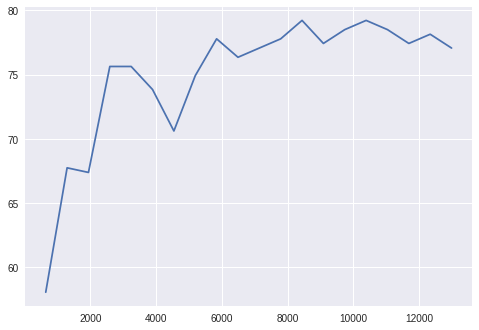

In [14]:
plt.plot(log['accuracy_step'], log['accuracy'])

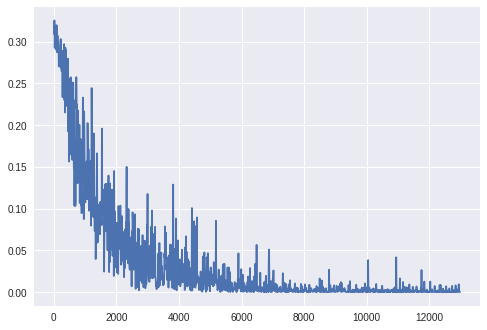

In [15]:
plt.plot(log['loss_step'], log['loss'])